## **Diversity of Animals in New York**
### **Fall 2025 Data Science Project**
**Contributers:**
- Abigail Min: Project Idea, Writing of introduction, Data Curation
- Joel Kim: Preprocessing, Exploratory Data Analysis
- Emily Wang: ML Algorithm Design/Development, ML Algorithm Training and Test Data Analysis

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB

### **1. Introduction**

The overall objective of this project is to analyze the biodiversity data of the state of New York. The data was taken from the data catalog from the NYS Department of Environmental Conservation, which logs several datasets for the status of plant and animal species. The data  includes information such as rare animals and plants, as well as significant natural communities. Data has been compiled sinced 1990 and is still added to today.

Throughout this tutorial, we will be trying to look for possible trends between various species' statuses, including their rarity and if they are heterogenous. We will look at both animal and plant species.

### **2. Data Curation**

To start, we need to access the data and get it in a readable format. Here, we will focus on collecting the data.

The data we will be using is from the website https://catalog.data.gov/dataset/biodiversity-by-county-distribution-of-animals-plants-and-natural-communities. We will be putting the data into a dataframe using Pandas tools for manipulation. Download the csv file from the website, and place it in the same folder as this file. Please ensure that the file is called "Biodiversity_by_County_-_Distribution_of_Animals__Plants_and_Natural_Communities.csv"; if you want to change the name, make sure you change the csv_path later!

First, we must import all the tools that we need for the process. 

In [2]:
#Packages Needed for Tutorial
#%pip install [package]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re

%matplotlib inline


If you are having issues downloading any of these packages, please uncomment and use the '%pip install [package]' command, replacing the [package] as needed.

If you need more assistance, take a look at this site:
https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

#### **Setting up data for analysis**
Here we are importing the data from the csv file that contains all of the biodiversity information. We need to read it, organize the data by cleaning the column names, and normalize the string fields. Because the data can contain non alphnumeric characters, lets remove all special characters.

In [3]:

# (a) Import
# If you renamed your csv file, ensure the csv_path is your new file name!
csv_path = "Biodiversity_by_County_-_Distribution_of_Animals__Plants_and_Natural_Communities.csv"
df_raw = pd.read_csv(csv_path)

# Organize: Clean column names
def clean_cols(cols):
    return [re.sub(r'[^0-9a-zA-Z_]+', '', c.strip().lower().replace(' ', '_')) for c in cols]

df = df_raw.copy()
df.columns = clean_cols(df.columns)

# Normalize string fields
text_cols = ['county','category','taxonomic_group','taxonomic_subgroup','scientific_name','common_name',
             'ny_listing_status','federal_listing_status','state_conservation_rank','global_conservation_rank',
             'distribution_status']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip()



To better group the data, we want to shift the year rages so that they have the same format. We will be using regular expressions (regex) to pattern match and consolidate the data.

In [4]:
# (b) Parse: year ranges into numeric start/end/mid; listing flags to ints; rarity scores to numeric
def parse_year_range(s):
    if not isinstance(s, str) or s.strip() == "":
        return pd.NA, pd.NA, pd.NA
    s = s.strip().lower()
    m_range = re.match(r'^(\d{4})\s*[-–]\s*(\d{4})$', s)
    if m_range:
        y1, y2 = int(m_range.group(1)), int(m_range.group(2))
        return y1, y2, int(round((y1 + y2) / 2))
    m_single = re.match(r'^(\d{4})$', s)
    if m_single:
        y = int(m_single.group(1))
        return y, y, y
    return pd.NA, pd.NA, pd.NA

yr_cols = df['year_last_documented'].apply(parse_year_range).tolist()
yr_df = pd.DataFrame(yr_cols, columns=['year_last_documented_start','year_last_documented_end','year_last_documented_mid'])
df = pd.concat([df.drop(columns=['year_last_documented']), yr_df], axis=1)

def s_rank_to_score(s):
    if not isinstance(s, str) or s.strip() == "":
        return np.nan
    s = s.upper()
    m = re.search(r'S([1-5])', s)
    if m:
        digit = int(m.group(1))
        return 6 - digit  # S1 -> 5 (rare) ... S5 -> 1 (common)
    if s.strip().startswith('SH') or s.strip().startswith('SX'):
        return 5
    if s.strip().startswith('SN') or s.strip().startswith('SU'):
        return 0
    return np.nan

NEG_LISTING = {"", "none", "n/a", "na", "not listed", "notlisted", "game with open season", "game", "open season"}
def listed_flag(x):
    return 0 if str(x).strip().lower() in NEG_LISTING else 1

df['state_conservation_score']   = df['state_conservation_rank'].apply(s_rank_to_score)
df['federally_listed_flag'] = df['federal_listing_status'].apply(listed_flag).astype(int)
df['state_listed_flag']     = df['ny_listing_status'].apply(listed_flag).astype(int)


We also do not want there to be any duplicates; we want to remove any duplicates and store it separately.

In [5]:
# (c) Organize: one-record-per-(county,species); keep a tidy pandas DataFrame
df_unique = df.drop_duplicates(subset=['county','scientific_name']).copy()

# Quick dataset profile (meets "what are the main characteristics? how many features/entries?")
profile = {
    "n_rows_raw": len(df_raw),
    "n_rows_clean": len(df),
    "n_unique_species_records": len(df_unique),
    "n_counties": df_unique['county'].nunique(),
    "n_features": df_unique.shape[1],
    "columns": df_unique.columns.tolist()
}
profile

{'n_rows_raw': 20507,
 'n_rows_clean': 20507,
 'n_unique_species_records': 20507,
 'n_counties': 66,
 'n_features': 17,
 'columns': ['county',
  'category',
  'taxonomic_group',
  'taxonomic_subgroup',
  'scientific_name',
  'common_name',
  'ny_listing_status',
  'federal_listing_status',
  'state_conservation_rank',
  'global_conservation_rank',
  'distribution_status',
  'year_last_documented_start',
  'year_last_documented_end',
  'year_last_documented_mid',
  'state_conservation_score',
  'federally_listed_flag',
  'state_listed_flag']}

Now our data is ready to be used for analysis!

### **Exploratory Data Analysis**

Now we will be exploring the organized data in a couple of methods. 

#### Method 1 — Composition & Outliers (Descriptive Statistics)
**Goal:** Identify **over-represented categories/taxa** and **outlier counties** in species richness.  
**Plot:** Bar charts (category composition; Top-15 counties).

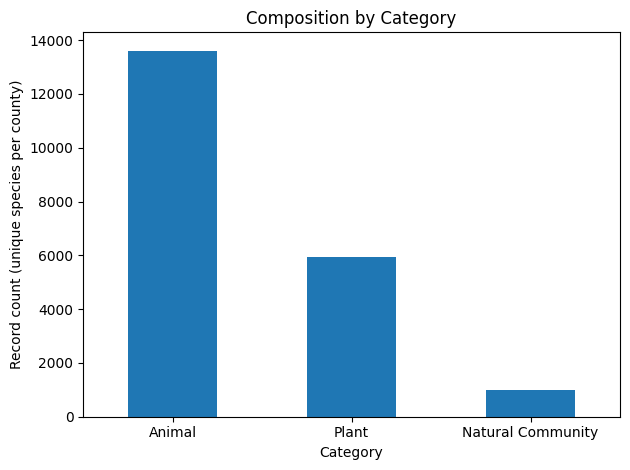

{'count': 66.0, 'mean': 310.7121212121212, 'std': 118.64423421453868, 'min': 1.0, '25%': 250.25, '50%': 321.0, '75%': 372.75, 'max': 733.0}


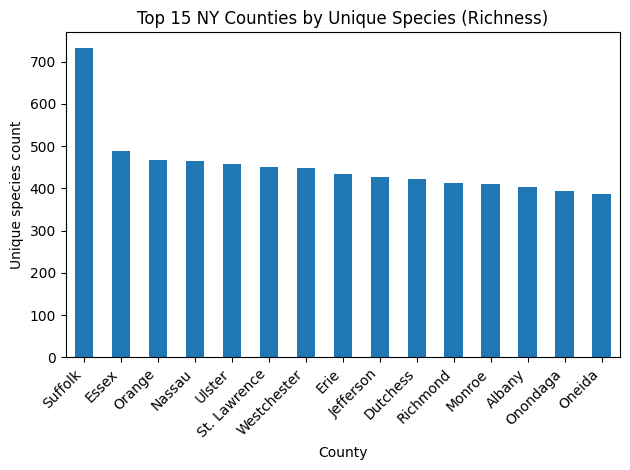

{'n_outlier_counties_by_richness': 1}


county
Suffolk    733
Name: scientific_name, dtype: int64

In [6]:

# Category composition (over-representation)
cat_counts = df_unique['category'].value_counts().sort_values(ascending=False)

plt.figure()
cat_counts.plot(kind='bar')
plt.title("Composition by Category")
plt.xlabel("Category")
plt.ylabel("Record count (unique species per county)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Species richness by county
species_by_county = df_unique.groupby('county')['scientific_name'].nunique().sort_values(ascending=False)
desc = species_by_county.describe()
print(desc.to_dict())

# Outliers via IQR
Q1, Q3 = species_by_county.quantile(0.25), species_by_county.quantile(0.75)
IQR = Q3 - Q1
upper_fence = Q3 + 1.5*IQR
outliers = species_by_county[species_by_county > upper_fence]

top15 = species_by_county.head(15)
plt.figure()
top15.plot(kind='bar')
plt.title("Top 15 NY Counties by Unique Species (Richness)")
plt.xlabel("County")
plt.ylabel("Unique species count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print({"n_outlier_counties_by_richness": int(outliers.shape[0])})
outliers.head(10)



#### Method 2 — Correlation Analysis  
**Question:** Are **rare species** concentrated where **total species** are high?  
**Method:** Pearson correlation (county-level).  
**Plot:** Scatter with fitted regression line (legend-labeled).


{'pearson_r': np.float64(0.8944814510909985), 'p_value': np.float64(4.679143904462256e-24)}


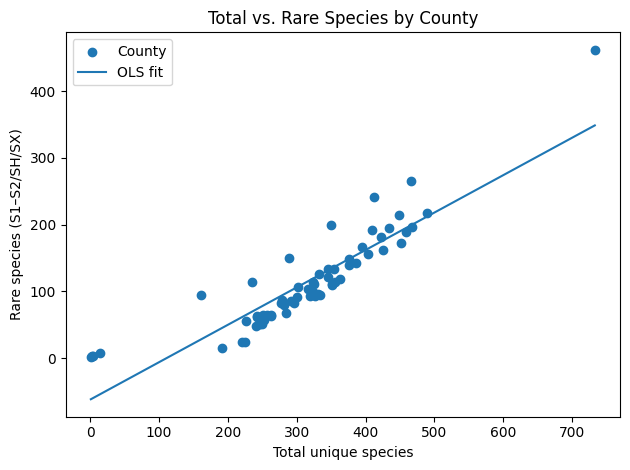

In [7]:

rare_mask = df_unique['state_conservation_score'] >= 4  # S1–S2, SH/SX
rare_counts = df_unique[rare_mask].groupby('county')['scientific_name'].nunique()

county_df = pd.DataFrame({
    'total_species': species_by_county,
    'rare_species': rare_counts
}).fillna(0)

r, p = stats.pearsonr(county_df['total_species'], county_df['rare_species'])
print({"pearson_r": r, "p_value": p})

x = county_df['total_species'].values
y = county_df['rare_species'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.figure()
plt.scatter(x, y, label="County")
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, label="OLS fit")
plt.title("Total vs. Rare Species by County")
plt.xlabel("Total unique species")
plt.ylabel("Rare species (S1–S2/SH/SX)")
plt.legend()
plt.tight_layout()
plt.show()



#### Method 3 — Hypothesis Testing
**Question:** Do **Animals** and **Plants** have the **same rarity distribution**?  
**Method:** Mann–Whitney U (non-parametric; compares medians/distributions).  
**Plot:** Boxplot of `state_rarity_score` by category.


{'n_animals': 13611, 'n_plants': 5921}
{'test': 'Mann-Whitney U', 'U': np.float64(9271259.5), 'p_value': np.float64(0.0)}


C:\Users\emily\AppData\Local\Temp\ipykernel_38596\2564556886.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a.values, b.values], labels=['Animal', 'Plant'])


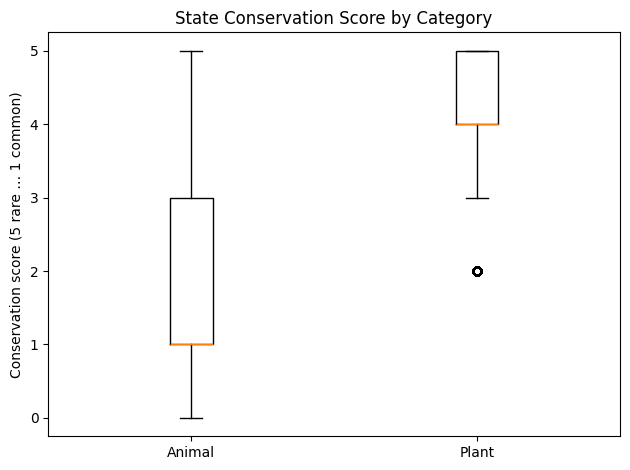

In [8]:

a = df_unique[df_unique['category'].str.upper()=='ANIMAL']['state_conservation_score'].dropna()
b = df_unique[df_unique['category'].str.upper()=='PLANT']['state_conservation_score'].dropna()

print({"n_animals": len(a), "n_plants": len(b)})
U, pval = stats.mannwhitneyu(a, b, alternative='two-sided')
print({"test": "Mann-Whitney U", "U": U, "p_value": pval})

plt.figure()
plt.boxplot([a.values, b.values], labels=['Animal', 'Plant'])
plt.title("State Conservation Score by Category")
plt.ylabel("Conservation score (5 rare … 1 common)")
plt.tight_layout()
plt.show()



#### **Three Conclusions**

**Conclusion 1 (Method 1 — Composition & Outliers):**  
Category composition is dominated by the most common class(es), and county **species richness** is **highly heterogeneous** with a small set of **outlier counties** (above the IQR upper fence), indicating uneven habitat diversity and/or survey effort.

**Conclusion 2 (Method 2 — Correlation):**  
There is a **strong positive correlation** between **total species** and **rare species** per county (high Pearson *r* with statistically significant *p*), implying that conserving species-rich counties protects a disproportionate share of rare taxa.

**Conclusion 3 (Method 3 — Hypothesis Test):**  
The **rarity score distributions** for **Animals** vs **Plants** are **significantly different** (Mann–Whitney U, *p* < 0.05), suggesting category-specific conservation strategies may be warranted.


### **Primary Analysis**

As the results of our exploratory analysis show a strong positive correlation between total species and the number of endangered species. We also noticed that although county species richness is generally similar, there are a few outlier counties. To further probe into our data, we'll be looking at how conservation rank is spread across different categories present in the data.

#### Taxonomic Group and Conservation Rank

First, we want to see what the distribution of state conservation ranks within each taxonomic group entails. 

In [9]:
group_list = df_unique['taxonomic_group'].unique()
print(df_unique['taxonomic_group'].unique())
print("Number of taxonomic groups: " + str(df_unique['taxonomic_group'].unique().size))

['Amphibians' 'Birds' 'Animal Assemblages' 'Bees, Wasps and Ants'
 'Butterflies and Moths' 'Dragonflies and Damselflies' 'Fish' 'Mammals'
 'Mussels and Clams' 'Other Animals' 'Reptiles'
 'Freshwater Nontidal Wetlands' 'Tidal Wetlands' 'Uplands' 'Conifers'
 'Ferns and Fern Allies' 'Flowering Plants' 'Mosses' 'Marine' 'Beetles'
 'Rivers and Streams' 'Lakes and Ponds' 'Flies' 'Snails' 'Stoneflies'
 'Subterranean' 'Mayflies']
Number of taxonomic groups: 27


We see that we have 27 taxonomic groups. We want to see what the distribution of conservation ranks are for each taxa. We can accomplish this by using the conservation scores we defined earlier and plotting frequencies on a bar graph. Here, we have graphed the frequencies for amphibians, butterflies and moths, and upland plants to highlight some of the patterns we saw throughout the groups.

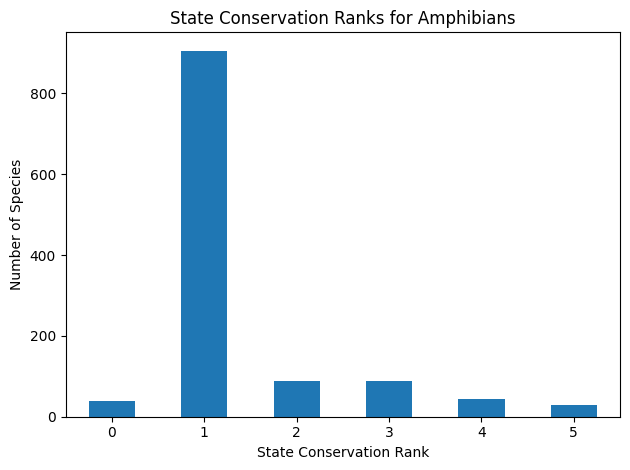

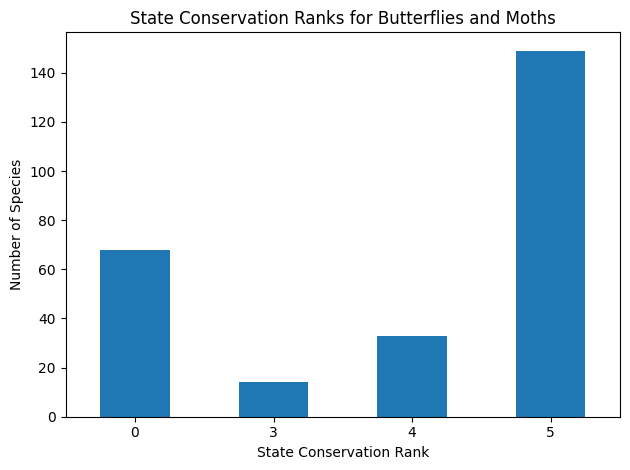

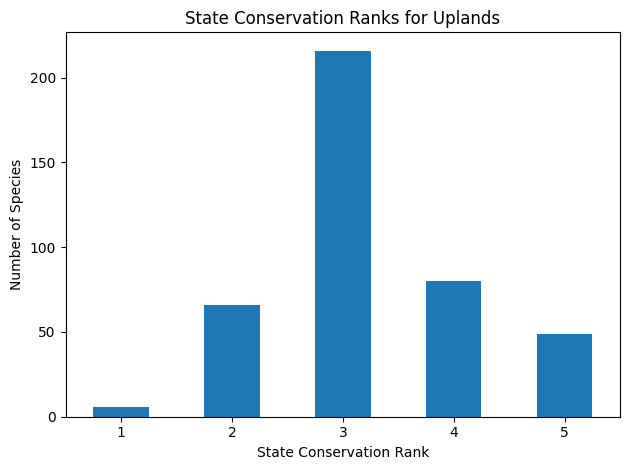

In [10]:
df_unique['state_conservation_score'] = pd.to_numeric(df_unique['state_conservation_score'])

def analyze_state_ranks(group) :
    group_df = df_unique[df_unique['taxonomic_group'] == group]
    rank_counts = group_df['state_conservation_score'].value_counts().sort_index()
    
    plt.figure()
    rank_counts.plot(kind='bar')
    plt.title("State Conservation Ranks for " + group)
    plt.xlabel("State Conservation Rank")
    plt.ylabel("Number of Species")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

analyze_state_ranks("Amphibians")
analyze_state_ranks("Butterflies and Moths")
analyze_state_ranks("Uplands")

#### County and Conservation Rank

Let's take a look at another facet of the data as well: county and state conservation rank.

In [11]:
county_list = df_unique['county'].unique()
print(df_unique['county'].unique())
print("Number of counties: " + str(df_unique['county'].unique().size))

['Albany' 'Dutchess' 'Fulton' 'Allegany'
 'Atlantic Ocean and Long Island Sound' 'Bronx' 'Erie' 'Broome'
 'Cattaraugus' 'Cayuga' 'Chautauqua' 'Chemung' 'Chenango' 'Clinton'
 'Essex' 'Columbia' 'Cortland' 'Counties Unknown' 'Delaware' 'Franklin'
 'Genesee' 'Greene' 'Hamilton' 'Herkimer' 'Jefferson' 'Kings'
 'Lake Erie Open Waters' 'Lake Ontario Open Waters' 'Lewis' 'Livingston'
 'Madison' 'Monroe' 'Montgomery' 'Nassau' 'New York' 'Niagara' 'Oneida'
 'Onondaga' 'Orange' 'Ontario' 'Orleans' 'Oswego' 'Otsego' 'Putnam'
 'Queens' 'Rensselaer' 'Richmond' 'Rockland' 'Saratoga' 'Schenectady'
 'Schoharie' 'Schuyler' 'Seneca' 'St. Lawrence' 'Steuben' 'Suffolk'
 'Sullivan' 'Tioga' 'Tompkins' 'Ulster' 'Warren' 'Washington' 'Wayne'
 'Westchester' 'Wyoming' 'Yates']
Number of counties: 66


We have 66 counties. Let's visualize the distribution of state conservation ranks based on county. 

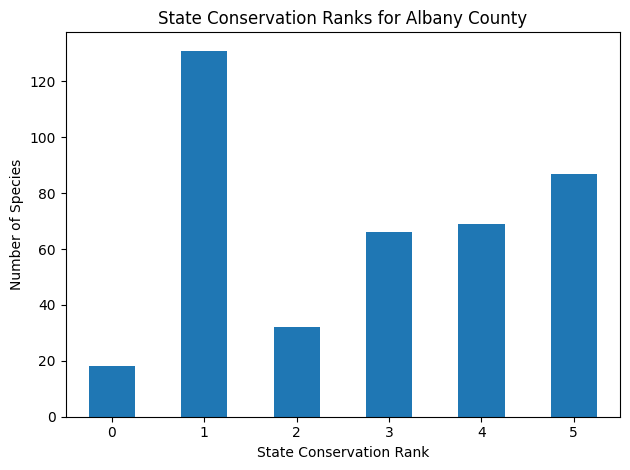

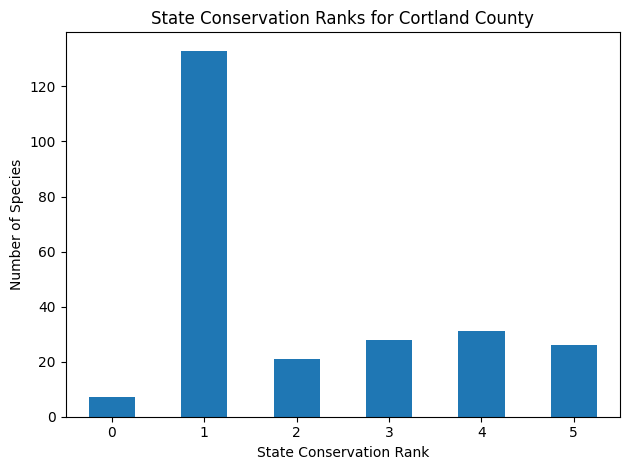

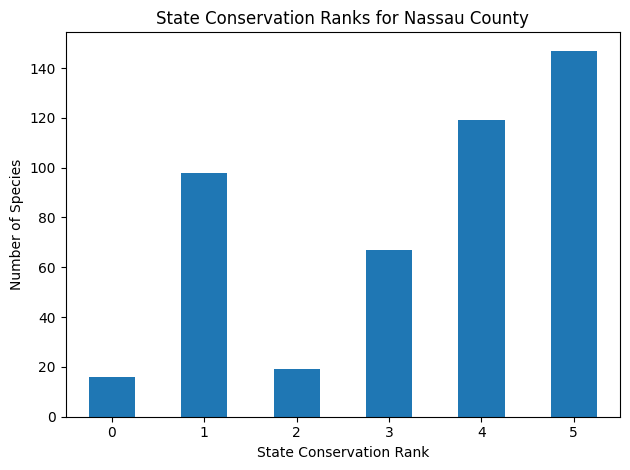

In [46]:
def analyze_county_ranks(county) :
    group_df = df_unique[df_unique['county'] == county]
    rank_counts = group_df['state_conservation_score'].value_counts().sort_index()
    
    plt.figure()
    rank_counts.plot(kind='bar')
    plt.title("State Conservation Ranks for " + county + " County")
    plt.xlabel("State Conservation Rank")
    plt.ylabel("Number of Species")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

analyze_county_ranks("Albany")
analyze_county_ranks("Cortland")
analyze_county_ranks("Nassau")

From the ones we highlighted, we can see that the general shape of Albany and Nassau county seems to be a dominant distribution with a few outliers like Cortland county. We can see here that the distribution of conservation ranks differs from the distribution based on taxonomic group. Now we're starting to lean towards creating a model to help rank species. 

#### Classifer Creation

What if we discovered a new species in New York? Let's create a classification algorithm to help predict what the conservation rank might be. We must use a classification algorithm because our data is all categorical; although the rank appears numerical, it's not a continuous variable and therefore we cannot use a regression algorithm. First, we need to split our data into a training dataset and a testing dataset. The training dataset will be what we feed into our model so that it can learn the patterns we're targeting. Then, once the model has been trained, we'll use it on the testing dataset to make sure the model works well. 

First, we need to convert our categorical data into numerical data since models won't accept strings. Our features will be the county, taxonomic group, federal listing status, and global conservation rank. 

In [18]:
county_target_encoding = df_unique.groupby('county')['state_conservation_score'].mean().to_dict()
df_unique['county_num'] = df_unique['county'].map(county_target_encoding)

taxonomic_target_encoding = df_unique.groupby('taxonomic_group')['state_conservation_score'].mean().to_dict()
df_unique['taxonomic_num'] = df_unique['taxonomic_group'].map(taxonomic_target_encoding)

fed_listing_target_encoding = df_unique.groupby('federal_listing_status')['state_conservation_score'].mean().to_dict()
df_unique['federal_listing_num'] = df_unique['federal_listing_status'].map(fed_listing_target_encoding)

def g_rank_to_score(s):
    if not isinstance(s, str) or s.strip() == "":
        return np.nan
    s = s.upper()
    m = re.search(r'G([1-5])', s)
    if m:
        digit = int(m.group(1))
        return 6 - digit  # S1 -> 5 (rare) ... S5 -> 1 (common)
    if s.strip().startswith('GH') or s.strip().startswith('GX'):
        return 5
    if s.strip().startswith('GN') or s.strip().startswith('GU'):
        return 0
    return np.nan

df_unique['global_conservation_score'] = df_unique['global_conservation_rank'].apply(g_rank_to_score)


In [21]:
pre_training_df = df_unique[['county_num', 'taxonomic_num', 'federal_listing_num', 'state_conservation_score', 'global_conservation_score']]
pre_X_train, pre_X_test = train_test_split(pre_training_df, test_size = 0.2, random_state = 42)
Y_train = pre_X_train['state_conservation_score']
X_train = pre_X_train.drop('state_conservation_score', axis = 1)
Y_test = pre_X_test['state_conservation_score']
X_test = pre_X_test.drop('state_conservation_score', axis = 1)

We're going to use the Random Forest Classifier to predict what the state conservation score will be based on other aspects of the species.

In [37]:
model = RandomForestClassifier(n_estimators = 250, random_state = 42)
model.fit(X_train, Y_train)

,n_estimators,250
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Now, we need to assess how good our classifier is. To do this, we'll use the test data that we made and run it through the classifier. We'll then compare it to the Y_test data to see how well the classifier did. 

In [39]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy report: ")
print(accuracy)

Accuracy report: 
0.5901999024865919


Ok, our accuracy for the random forest classifier wasn't great. let's try another one.

In [40]:
nb_model = CategoricalNB()
nb_model.fit(X_train, Y_train)

y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy report: ")
print(accuracy)

Accuracy report: 
0.583130180399805


As the results of our exploration show, there is a strong linear correlation between the total species count and the rare species count of a county. We will create a linear regression model to predict, based on a county's total species number, how many rare species it will have.

#### Training and Testing Dataset Creation
To start, we will create the appropriate datasets for our model to learn.

In [ ]:
X_train, X_test = train_test_split(county_df, test_size=0.2, random_state=42, )

Now, we will train the linear regression model to our data. 

In [ ]:
model = LinearRegression().fit(X_train[['total_species']], X_train['rare_species'])
Y_train = model.predict(X_train[['total_species']])

Let's see what our model looks like in comparison to our training and testing data!

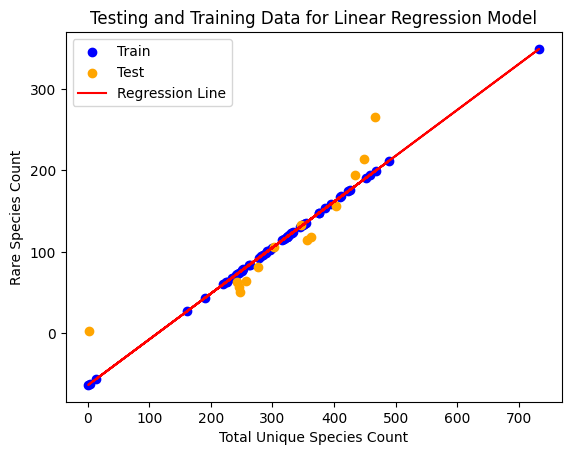

In [ ]:
plt.scatter(X_train[['total_species']], Y_train, color='blue', label='Train')
plt.scatter(X_test[['total_species']], X_test['rare_species'], color='orange', label='Test')
plt.plot(X_train[['total_species']], Y_train, color='red', label='Regression Line')
plt.title("Testing and Training Data for Linear Regression Model")
plt.xlabel("Total Unique Species Count")
plt.ylabel("Rare Species Count")
plt.legend()
plt.show()

### **Visualization**

We can see how important each feature is to predicting the state conservation score by looking at the feature_importances array the classifier outputed. We can visualize this with a graph like this:

Text(0.5, 1.0, 'Feature Importance in Random Forest Classifier')

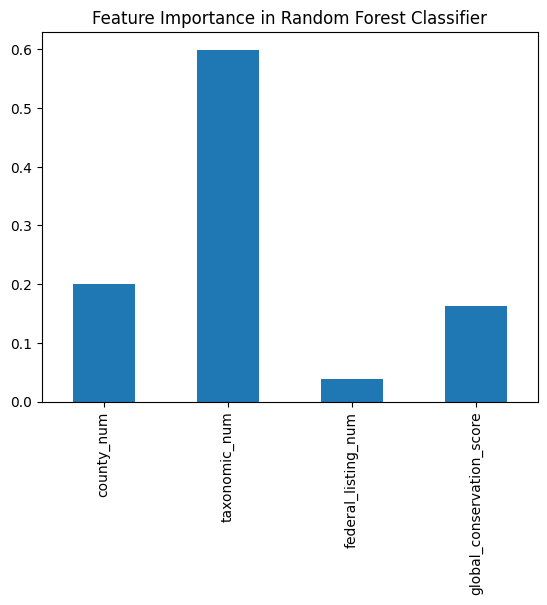

In [45]:
feature_names = ['county_num', 'taxonomic_num', 'federal_listing_num', 'global_conservation_score']
feature_importances = pd.Series(model.feature_importances_, index = feature_names)
plt.figure()
feature_importances.plot(kind='bar')
plt.title("Feature Importance in Random Forest Classifier")

### **Insights and Conclusions**

We learned a couple things from our data and our classifer.

Our data shows a variety of flora and fauna throughout New York, signaling good ecological diversity. Unfortunately, there are endangered species throughout New York, signaling a need for programs to fight ecological damage to vulnerable populations. Our goal in creating this random forest classifier was to create a tool to help predict the conservation status of newly discovered species in New York given the location of the species, the taxonomic group the species belonged to, the federal status of the species, and the global conservation rank of the species if it existed elsewhere.

Through our random forest classifier model, we learned that the taxonomic category had the largest impact on predicting the state conservation score, highlighting that a species' taxonomy group plays a large role in how it is impacted by the environment. The county played the second largest role in prediction, showing that the local environment also plays a significant part in classification of a species into its conservation rank. The federal listing played the least important role. This may show that federal-level classifications are too broad or it may also be due to a smaller classification depth at the federal level; the federal level only contained 6 labels while the other categories either contained more labels or numerical data with a heavy emphasis on the numbers themselves.

The hard part about creating a predictive model for ecological data is the oversimplification of ecological connectivity and impact from a limited amount of data. While location, taxonomic group, and ecological status at the federal and global level give us a general glimpse at the species' environment, role in the ecosystem, and data from other parts of the world, it does not give us enough information to make a strong model to predict state conservation rank. 

We hope that you have learned a little more about the environment and ecosystem of New York state and the difficulties that come with predicting as dense of a connected system as that of nature. 